In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

In [2]:
data_dir = '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom'

In [3]:
dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
dirs.sort(key=lambda x: x.stem.split('-')[1:])
dirs

[PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Kyra-2025-03-25-00-04-31'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Kyra-2025-03-25-00-06-41'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Emilia-2025-03-25-00-11-15'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Bella-2025-03-25-00-21-27'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Bella-2025-03-25-00-22-31'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Kaylin-2025-03-25-00-24-22'),
 PosixPath('/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom/Kaylin-2025-03-25-00-26-08')]

In [ ]:
d = dirs[7]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')

print(df_emg.shape, df_imu.shape)

i=6
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape)

# df_emg.to_csv(d / 'emg.csv', index=False)
# df_imu.to_csv(d / 'imu.csv', index=False)


Kaylin-2025-03-25-00-26-08
(25751, 2) (2576, 7) {'name': 'Kaylin', 'age': 20, 'weight': 135, 'sex': 'F', 'location': 'Strom', 'machine_weight': 20, 'start_time': 1742876768.0201616, 'notes': '', 'end_rep_markers': [6.874183416366577, 9.498876094818115, 12.153429508209229, 15.017692804336548, 18.052417755126953, 20.9947829246521, 24.28623938560486, 27.5127215385437, 30.82857656478882]}
Total reps: 9
Rep 1/9: 6.87 s
Rep 2/9: 2.62 s
Rep 3/9: 2.65 s
Rep 4/9: 2.86 s
Rep 5/9: 3.03 s
Rep 6/9: 2.94 s
Rep 7/9: 3.29 s
Rep 8/9: 3.23 s
Rep 9/9: 3.32 s
(24702, 3) (2471, 8) {'name': 'Kaylin', 'age': 20, 'weight': 135, 'sex': 'F', 'location': 'Strom', 'machine_weight': 20, 'start_time': 1742876768.0201616, 'notes': '', 'end_rep_markers': [6.874183416366577, 9.498876094818115, 12.153429508209229, 15.017692804336548, 18.052417755126953, 20.9947829246521, 24.28623938560486, 27.5127215385437, 30.82857656478882]}


Text(0.5, 0.98, 'Kaylin-2025-03-25-00-26-08')

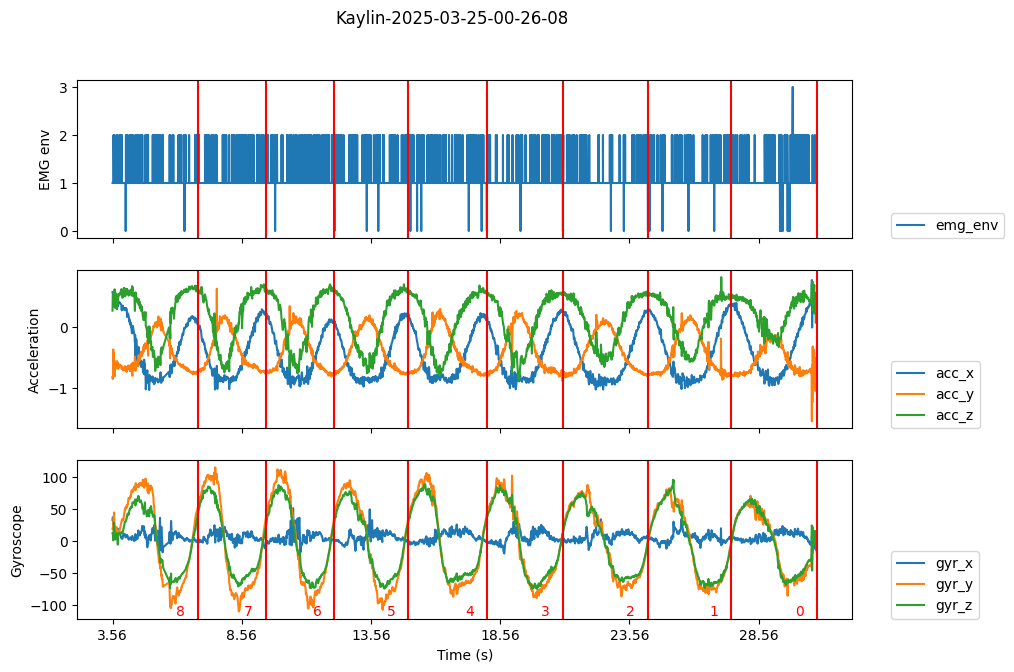

In [6]:
## FOR version 2 - emg.csv (1000 Hz) and imu.csv (100 Hz) - values not normalized
d = dirs[6]

print(d.name)
df_emg = pd.read_csv(d / 'emg.csv')
df_imu = pd.read_csv(d / 'imu.csv')
info = json.load(open(d / 'info.json'))
print(df_emg.shape, df_imu.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df_emg['rir'] = -1
df_imu['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df_emg.loc[df_emg['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
df_imu.loc[df_imu['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df_emg.loc[df_emg['time'].between(start, end), 'rir'] = total_reps - i - 2
    df_imu.loc[df_imu['time'].between(start, end), 'rir'] = total_reps - i - 2
df_emg = df_emg[df_emg['rir'] != -1]
df_imu = df_imu[df_imu['rir'] != -1]

i=0
df_emg = df_emg.iloc[int(i*1000):]
df_imu = df_imu.iloc[int(i*100):]
print(df_emg.shape, df_imu.shape, info)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df_emg['time'], df_emg['emg_env'], label='emg_env')
axes[1].plot(df_imu['time'], df_imu[['acc_x', 'acc_y', 'acc_z']] / 16384.0, label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df_imu['time'], df_imu[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0, label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(
    min(df_emg['time'].iloc[0], df_imu['time'].iloc[0]), 
    min(df_emg['time'].iloc[-1], df_imu['time'].iloc[-1]),
    5
))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df_emg['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

Noodles-2025-03-06-23-24-09
(4157, 8) {'name': 'Noodles', 'age': 19, 'weight': 140, 'sex': 'm', 'start_time': 1741321449.6383467, 'end_rep_markers': [4.5, 6.8, 9.1, 11.4, 13.7, 16.0, 18.3, 20.6, 23.3, 26.5], 'notes': 'no end of rep annot, 90lb, studio fit'}
Total reps: 10
Rep 1/10: 4.50 s
Rep 2/10: 2.30 s
Rep 3/10: 2.30 s
Rep 4/10: 2.30 s
Rep 5/10: 2.30 s
Rep 6/10: 2.30 s
Rep 7/10: 2.30 s
Rep 8/10: 2.30 s
Rep 9/10: 2.70 s
Rep 10/10: 3.20 s
(3288, 9)


Text(0.5, 0.98, 'Noodles-2025-03-06-23-24-09')

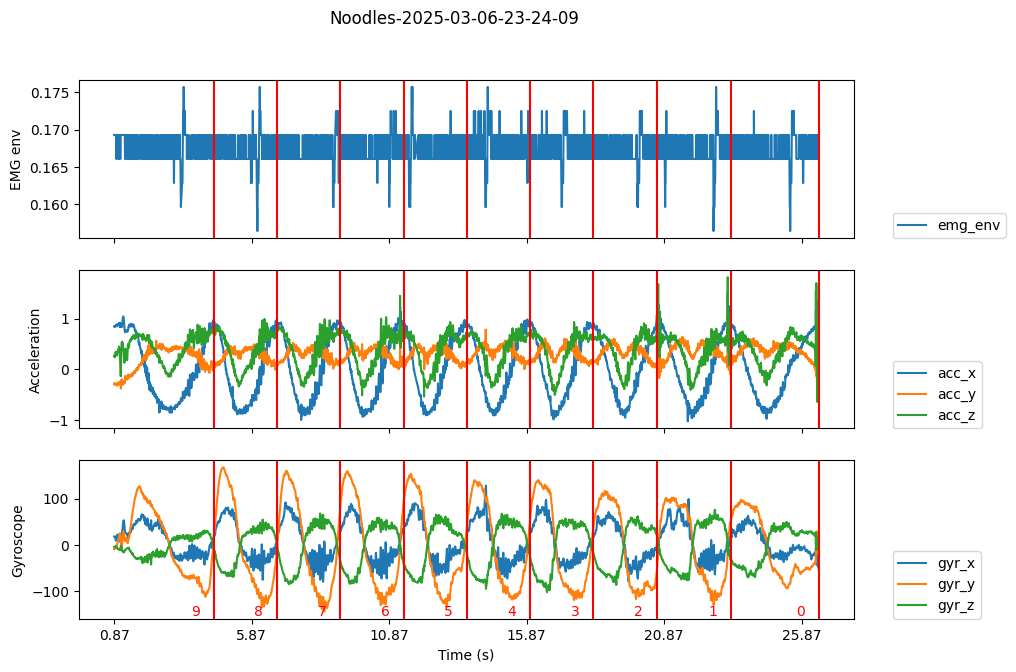

In [33]:
## FOR version 1 - emg and imu in one file (data.csv) - values already normalized

d = dirs[0]

print(d.name)
df = pd.read_csv(d / 'data.csv')
df['emg_env']
info = json.load(open(d / 'info.json'))
print(df.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
df = df[df['rir'] != -1]

i=0
df = df.iloc[int(i*100):]
print(df.shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df['time'], df['emg_env'], label='emg_env')
axes[1].plot(df['time'], df[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df['time'], df[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(df['time'].iloc[0], df['time'].iloc[-1], 5))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [2]:
def label_rir(df, info):
    total_reps = len(info['end_rep_markers'])
    df['rir'] = -1
    df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
    for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
        df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
    df = df[df['rir'] != -1]

In [3]:
data_dirs = [
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-07-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-11-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-3-15-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-3-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-7-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-14-25',
    '/Users/musa/Desktop/raspberrypi-recordings/recordings-4-15-25-strom',
]

In [4]:
not_labelled_each = [[],[],[],[],[],[],[]]
use_old = [True, True, True, False, False,False,False]
dfs =[]
outdir = Path('data/')
outdir.mkdir(exist_ok=True, parents=True)
session_id = 0
if len(use_old) != len(data_dirs):
    raise ValueError('Length of use_old must match length of data_dirs')
for data_dir, not_labelled, use_oldi in zip(data_dirs, not_labelled_each, use_old):
    dirs = [d for d in Path(data_dir).iterdir() if d.is_dir()]
    for d in [dirs[i] for i in range(len(dirs)) if i not in not_labelled]:
        name = d.name.split('-')[0]
        if use_oldi:
            df = pd.read_csv(d / 'data.csv').drop(columns=['emg_env'])
        else:
            df = pd.read_csv(d / 'imu.csv')
            df[['acc_x', 'acc_y', 'acc_z']] = df[['acc_x', 'acc_y', 'acc_z']] / 16384.0
            df[['gyr_x', 'gyr_y', 'gyr_z']] = df[['gyr_x', 'gyr_y', 'gyr_z']] / 131.0
        
        info = json.load(open(d / 'info.json'))
        label_rir(df, info)
        
        df['id'] = name
        df['session_id'] = session_id
        df = df[df['rir'] != -1]    # cut off after last rep
        dfs.append(df)
        session_id += 1
df = pd.concat(dfs)
df.to_csv(outdir / 'data.csv', index=False)

In [318]:
X = df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
y = df['rir'].values

In [319]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [320]:
hz = 100
X_windowed = []
y_windowed = []
window_t = 2.5
window_size = int(hz * window_t)    # 2.5 seconds
stride_t = 0.5
stride = int(hz * stride_t)         # 0.5 seconds
for i in range(0, len(X) - window_size, stride):
    X_windowed.append(X[i:i+window_size])
    y_windowed.append(y[i:i+window_size].mean())
X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
print(X_windowed.shape, y_windowed.shape)

(2880, 250, 6) (2880,)


Text(0.5, 1.0, 'Rir=10.0')

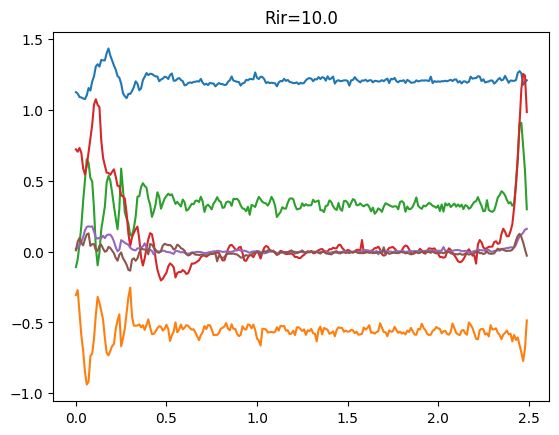

In [323]:
i = 0
plt.plot(X_windowed[i])
t = window_size / 5
tt = window_t / 5
plt.xticks(np.arange(0, window_size+1, t), np.arange(i*stride_t, i*stride_t + window_t + tt, tt));
plt.title(f'Rir={y_windowed[i]}')

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1780, 250, 6) (445, 250, 6)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_test, y_pred)

In [184]:
regr.rvalue**2

np.float64(0.6565194283398438)

Text(0, 0.5, 'Predicted RIR')

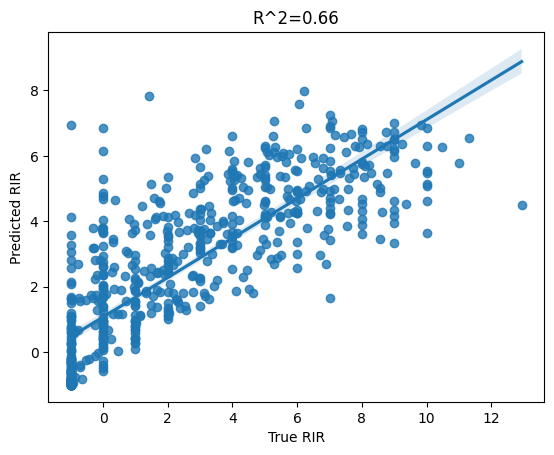

In [185]:
from scipy.stats import linregress
import seaborn as sns
regr = linregress(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.title(f'R^2={regr.rvalue**2:.2f}')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')